# 依據21點遊戲中，賭場玩家盛行的Hi-Lo算牌法，搭配統計學家John Kelly設計的Kelly Criterion賭注配置方程式以及基本策略，試行在不同遊戲次數下，是否真的會贏錢

首先定義21點的標準遊戲規則:
1.遊戲中有一位莊家，玩家最少一位，最多一般為六位或七位。 (在此次試驗中先以一位玩家做設計)

2.一開始莊家在每位玩家和自己面前發下兩張牌，但是莊家的兩張牌中，一張面朝上、一張覆蓋著，玩家的兩張牌均面朝上。

3.發完牌之後玩家依序決定是否要補牌，等全部的玩家做完決定之後，就換莊家補牌，最後玩家就和莊家比較牌的點數來決定輸贏。

4.牌的點數算法為：A可當1點或11點，10、J、Q、K當作10點，其餘的牌就以其牌面當作點數。如：(A，8)可當作9點或19點，(7，Q)為17點，(4，6，8)為18點。

5.在計算點數時，21點為最高點，超過21點稱為爆點(Burst)，將被視為最小的點數，此時玩家立即喪失籌碼。

6.若玩家一開始得到兩張一樣的牌(pair)，則可選擇是否分牌(split)，即將原先一對的牌拆成兩注(玩家也必須將籌碼加倍並平分壓在兩注上)，此兩注分別再獲得一張發牌，且不得再補牌。

6.莊家在替自己補牌時，如果點數為16點或16點以下時，就必須補牌，一旦點數為17點或以上時，則不得補牌。

7.此處假設沒有加注以及投降、保險的規則。

8.遊戲時的牌為六副完整地撲克牌組合而成，因此初始每一種數字皆會有4*6=24張 (能代表10點的有4*4*6=96張)

9.當遊戲進行到剩餘的牌剩下原先的一半以下(161張)時，則將所有牌重新洗入牌堆遊戲

規則請參考維基:https://zh.wikipedia.org/wiki/%E4%BA%8C%E5%8D%81%E4%B8%80%E9%BB%9E

再來定義勝負的計算

1.若玩家發生爆點，則該輪籌碼直接歸莊家

2.若玩家得到Biackjack (一開始得到的兩張牌為一張A以及一張能代表十點的牌)，則不計算莊家點數，玩家直接獲得1.5倍籌碼

3.若莊家爆點且玩家沒有爆點，則玩家直接獲得1倍的籌碼(若玩家也爆點則沒有獲利)

4.若雙方都沒有發生爆點，則依據大小比較，玩家點數大則獲得一倍籌碼，莊家大則玩家失去該輪籌碼，一樣大則玩家可拿回原賭注


In [48]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

首先創建一個矩陣，用來儲存每一種點數以及其剩餘的牌數

In [83]:
CardRemain=np.array([
#點數 牌數
[0,0],
[1,24],
[2,24],
[3,24],
[4,24],
[5,24],
[6,24],
[7,24],
[8,24],
[9,24],
[10,96],
#J、Q、K以及10點在遊戲中皆視為10
#為了方便辨識，讓點數和直接對應到列數，在前面填充0
])

基本策略
建立21點基本策略(當拿到對應的組合以及點數時，效益最大的動作)
策略是根據玩家一開始得到的兩張牌之組合，所做勝率最大的動作
各項代號所對應的動作

H:跟莊家要牌

S:不要牌，直接以手中的牌與莊家比大小

P:分牌

較清楚的基本策略表請參考:https://www.blackjackinfo.com/blackjack-basic-strategy-engine/ (因為沒有加注(D)，則D皆以H取代)
不同情況適用的矩陣

hard:兩張手牌不相同且沒有A時

soft:兩張手牌不相同且有一張A時

pair:兩張手牌相同時

In [8]:
hard =([
#     1   2   3   4   5   6   7   8   9   10 莊家手牌
['0','0','0','0','0','0','0','0','0','0','0'],
['0','0','0','0','0','0','0','0','0','0','0'],
['0','0','0','0','0','0','0','0','0','0','0'],
['0','0','0','0','0','0','0','0','0','0','0'],
['0','0','0','0','0','0','0','0','0','0','0'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','H','H','S','S','S','H','H','H','H'],
['0','H','S','S','S','S','S','H','H','H','H'],
['0','H','S','S','S','S','S','H','H','H','H'],
['0','H','S','S','S','S','S','H','H','H','H'],
['0','H','S','S','S','S','S','H','H','H','H'],
['0','S','S','S','S','S','S','S','S','S','S'],
['0','S','S','S','S','S','S','S','S','S','S'],
['0','S','S','S','S','S','S','S','S','S','S'],]
#列數則代表玩家手牌點數和，依序由5-18
#為了方便辨識，讓點數和直接對應到行列數，在前面填充0
)

soft=([
#     1   2   3   4   5   6   7   8   9   10  莊家手牌
['0','0','0','0','0','0','0','0','0','0','0'],
['0','0','0','0','0','0','0','0','0','0','0'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','S','S','S','S','S','S','S','H','H'],
['0','S','S','S','S','S','S','S','S','S','S'],
['0','S','S','S','S','S','S','S','S','S','S'],]
#列數則代表玩家A以外的手牌，依序由2-9
)

pair =t=([
#     1   2   3   4   5   6   7   8   9   10   莊家手牌
['0','0','0','0','0','0','0','0','0','0','0'],
['0','P','P','P','P','P','P','P','P','P','P'],
['0','H','P','P','P','P','P','P','H','H','H'],
['0','H','P','P','P','P','P','P','H','H','H'],
['0','H','H','H','H','P','P','H','H','H','H'],
['0','H','H','H','H','H','H','H','H','H','H'],
['0','H','P','P','P','P','P','H','H','H','H'],
['0','H','P','P','P','P','P','P','H','H','H'],
['0','P','P','P','P','P','P','P','P','P','P'],
['0','S','P','P','P','P','P','S','P','P','S'],
['0','S','S','S','S','S','S','S','S','S','S'],

]
#列數則代表玩家成對手牌，依序由1-10
)


首先依據kelly公式，要從剩餘牌的組合中判斷每次應該要壓注多少金額
Kelly公式:壓注金額=(玩家所占優勢/所剩牌數約幾副牌)*1%*本金
*玩家所占優勢:運用Hi-Lo算牌法，小牌(2-6)代表+1 大牌(10-A)代表-1，其餘為0，將所有剩餘的牌對應的分數相加，再除上剩餘的牌大約有幾副，得到的數值稱為真數(Realnumber)，若真數>0(小牌偏多)，則牌局對玩家有利，應該下多注；反之則應下小注(此處假設最低注為10元，故當真數<0則下10元)。而根據統計，真數每增加一，玩家的勝率就提高0.5%，換言之，玩家獲勝與輸的差距會增加1%(勝率增0.5%敗率降0.5%)。因此，"真數每增加1，玩家所占優勢增加1%"

說明請參考:http://sportsfan168.com/article/2046.html

In [9]:
def Kelly(number,Money,B,S):
    Realnumber = (S-B)/(number/52)
    if Realnumber>0:
        return  int(Realnumber*0.01*Money)
    else:
        return 10

以下是模擬發一張牌的函數

In [10]:
def draw():
    card =np.random.choice([1,2,3,4,5,6,7,8,9,10],1,list(CardRemain[1:,1]/sum(CardRemain)[1])
    )
    CardRemain[card[0]][1]-=1
    return card[0]
        

製作一個紀錄每次測試獲益結果的矩陣

In [11]:
profit = np.zeros((2,20))
for r in range(0,20):
    profit[0][r] = (r+1)*50 #遊戲次數

最後就開始設定遊戲的進行以及每次玩家的對應行動

In [107]:
for k in range(0,20): #分別測試遊戲次數從50~1000次的績效
    TotalMoney= [] #紀錄每次遊戲後的剩餘資金
    TotalMoney.append(1000) #初始資金1000元
    for i in range(1,50*(k+1)+1): #依據k值決定由遊戲次數 每一次的迴圈代表一次遊戲
        big_number= CardRemain[10][1] + CardRemain[1][1] #大數 10-A
        small_number = sum(CardRemain[2:7,1]) #小數 2-6
        totalcard = sum(CardRemain)[1] #所有的剩餘牌數
        bit = Kelly(totalcard,TotalMoney[i-1],big_number,small_number)

        action = ''
        blackjack = 0 #若玩家得到 blackjack，則數值改為1
        blackjack2 = 0 #若分牌之後會產生第二個牌組，若此牌組得到 blackjack，則數值改為1
        playersum = 0 #玩家手牌數值的總和
        playersum2 =0 #若分牌之後會產生第二個牌組，此牌組的總和
        yourcard = [] #紀錄此次遊戲拿到的手牌
        dealerscard = [] #紀錄莊家此次遊戲拿到的手牌
        card1 = draw() #玩家拿到的第一張牌
        card2 = draw() #玩家拿到的第二張牌
        yourcard.append(card1)
        yourcard.append(card2)
        card3 = draw()  #這張牌是莊家的明牌
        card4 = draw() #這張牌是莊家的暗牌
        dealerscard.append(card3)
        dealerscard.append(card4)
        
#-------------依據一開始所得的兩張牌，選擇對應的基本策略----------------------
        if card1 == card2: #若得到的兩張手牌一樣，則看pair矩陣
            action = pair[card1][card3]
        elif 1 in  yourcard and 10 in yourcard: #前兩張合為21點，則必為blackjack，直接獲勝並得1.5倍籌碼
            blackjack = 1
        elif card1 ==1: #若第一張牌為A，則以第二張牌的數值對應soft矩陣
            action = soft[card2][card3]
        elif card2 ==1:#若第二張牌為A，則以第一張牌的數值對應soft矩陣
            action = soft[card1][card3]
        else: #若兩張牌不相同且沒有A，則以兩張牌的和對應hard矩陣
            action = hard[card1+card2][card3]
        #如果策略是一開始就不要牌
        if action =='S':
            playersum = sum(yourcard)
            if 1 in yourcard:
                playersum = sum(yourcard) -1 +11
                pass
        #如果策略是一開始要牌
        if  action == 'H':
            if 1 in yourcard: #如果一開始其中一張是1，則要討論不同的情況決定點數1的值是1還是11
                while soft[sum(yourcard)-1][card3]=='H': #除了點數1以外的所有數字之和來對應soft矩陣的策略
                    yourcard.append(draw())
                    playersum = sum(yourcard)
                    if sum(yourcard)-1 >9: #如果抽完這輪之後，點數1以外的數字和超過9，則不再以soft矩陣的策略看待之
                        break
                if sum(yourcard)-1 +11 <=21: #如果經過soft策略之後，其他牌的和<=10(e.g.把點數1的值當成11帶進去會<=21)時，則把數1的值當成11
                    playersum = sum(yourcard)-1 +11
                else: #若把點數1的值當成11帶進去會>21時，只能把點數1的值當作1，並回到hard的矩陣策略看待之
                    while hard[sum(yourcard)][card3]=='H':
                        yourcard.append(draw())
                        playersum = sum(yourcard)
                        if sum(yourcard)>17:
                            break                
            else:       
                while hard[sum(yourcard)][card3]=='H': #一開始沒有抽到1時
                    yourcard.append(draw())
                    playersum = sum(yourcard)
                    if sum(yourcard)>17:
                        break
                    if 1 in yourcard: #如果中途抽到1了，則要討論不同的情況決定點數1的值是1還是11
                        while sum(yourcard)-1 <10: #如果除了點數1以外的所有數字之和尚未超過10，則用soft矩陣的策略對應
                            if soft[sum(yourcard)-1][card3]=='H':
                                yourcard.append(draw())
                                playersum = sum(yourcard)
                            else: #如果除了點數1以外的所有數字之和超過10，則跳出soft策略
                                break
                        if sum(yourcard)-1 +11 <=21: #如果經過soft策略之後，其他牌的和<=10(e.g.把點數1的值當成11帶進去會<=21)時，則把數1的值當成11
                            playersum = sum(yourcard)-1 +11
                            break                
                        if sum(yourcard)-1 >10: #若把點數1的值當成11帶進去會>21時，只能把點數1的值當作1，並回到hard的矩陣策略看待之
                            continue



        if action =='P': #當P策略發生時，則需要分牌，產生第二組牌yourcard2
            yourcard =[card1,draw()]
            yourcard2 =[card2,draw()]
            playersum = sum(yourcard)
            if playersum == 21:
                blackjack += 1
            playersum2 = sum(yourcard2)
            if playersum2 == 21:
                blackjack2 +=1
#------------------------玩家要牌結束後，換莊家要牌----------------------------
        if 1 in dealerscard:
            if sum(dealerscard)-1+11 >=17 :
                dealersum = sum(dealerscard)-1+11
            else:
                pass
        while sum(dealerscard) <= 16:
            dealerscard.append(draw())
            dealersum = sum(dealerscard)
            if 1 in dealerscard:
                if sum(dealerscard)-1+11 >= 17 and sum(yourcard)-1+11 <= 21:
                    dealersum = sum(dealerscard)-1+11
                    break
#---------------------雙方要牌結束，比較勝負------------------------------
        if dealersum >21: #莊家爆點時，則直接算玩家勝，除非玩家也爆點
            if playersum2>0: #此時玩家有兩副牌，因此得到雙倍籌碼
                TotalMoney.append(TotalMoney[i-1]+2*bit)
            else:
                if blackjack==1:
                    TotalMoney.append(TotalMoney[i-1]+1.5*bit)                
                if blackjack==0 & playersum <= 21:
                    TotalMoney.append(TotalMoney[i-1]+bit)

                if blackjack==0 & playersum > 21:
                    TotalMoney.append(TotalMoney[i-1])
            continue
        else:
            if playersum > 21: #如果莊家爆點，直接判輸
                TotalMoney.append(TotalMoney[i-1]-bit)
            else:
                if blackjack ==1: #如果blackjack發生，則直接獲得1.5倍獎金
                    TotalMoney.append(TotalMoney[i-1]+1.5*bit)
                if blackjack ==0 and playersum > dealersum: #比較大小
                    TotalMoney.append(TotalMoney[i-1]+bit)
                if blackjack ==0 and playersum == dealersum:
                    TotalMoney.append(TotalMoney[i-1])
                    pass
                if blackjack ==0 and playersum < dealersum:
                    TotalMoney.append(TotalMoney[i-1]-bit)

            if playersum2 >0: #如果分牌發生時 注意分牌時因為只能各拿兩張牌，因此不可能爆點
                if blackjack2 ==1:
                    TotalMoney[i]+=1.5*bit
                if blackjack2 ==0 and playersum2 > dealersum:
                    TotalMoney[i]+=bit
                if blackjack ==0 and playersum == dealersum:
                    pass
                if blackjack ==0 and playersum < dealersum:
                    TotalMoney[i]-=bit
        if sum(CardRemain)[1]/312 <= 1/2 or i == 50*(1+k): #如果此局結束時，牌只剩一半不到，或是是此輪的最後一次遊戲，則牌組初始化
            CardRemain=np.array([
            [0,0],
            [1,24],
            [2,24],
            [3,24],
            [4,24],
            [5,24],
            [6,24],
            [7,24],
            [8,24],
            [9,24],
            [10,96],
            ])
    profit[1][k] = (TotalMoney[i]-1000)/1000*100

製作次數與報酬率(%)的散布圖

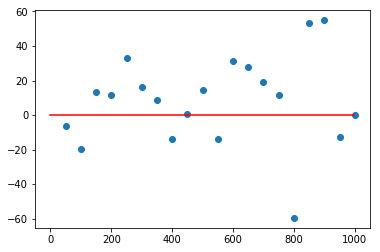

In [108]:
plt.scatter(profit[0],profit[1])

x=[]
y=[]
for s in range(0,1000):
    x.append(s)
    y.append(0) #零獲利的基準線
plt.plot(x,y,'r')

此時再試作次數對報酬率的回歸直線

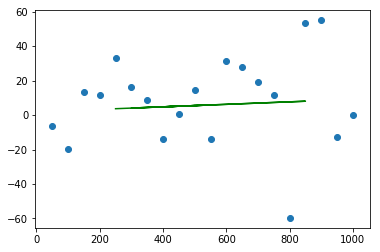

In [110]:
X = profit[0].reshape(len(profit[0]),1)
Y = profit[1].reshape(len(profit[1]),1)
x_train,x_test,y_train,y_test = train_test_split( X,Y,test_size=0.3,random_state=9487)
regr = LinearRegression()
regr.fit(x_train , y_train)
Y_pred = regr.predict(x_test)
plt.plot(x_test,Y_pred,'g') 
plt.scatter(profit[0],profit[1])

可以約略看出，此算牌以及賭注配置策略是有其優勢存在的，且綜觀此次試驗，當遊戲次數<400時，獲利機率較大，一旦提升遊戲次數至800次以上，可能得到更高的報酬率，但卻也有更高的可能性蒙受虧損。

# 若我們只取1000次的遊戲次數，來觀看其獲利曲線

In [103]:
#程式碼幾乎都和上面一樣，但是只看遊戲1000次時
TotalMoney= []
TotalMoney.append(1000) #初始資金1000元
compare = np.zeros((2,1001))
for i in range(1,1001):
    big_number= CardRemain[10][1] + CardRemain[1][1]
    small_number = sum(CardRemain[2:7,1])
    totalcard = sum(CardRemain)[1]
    bit = Kelly(totalcard,TotalMoney[i-1],big_number,small_number)
    
    action = ''
    blackjack = 0
    blackjack2 = 0
    playersum = 0
    playersum2 =0
    yourcard = []
    dealerscard = []
    card1 = draw()
    card2 = draw()
    yourcard.append(card1)
    yourcard.append(card2)
    card3 = draw()  #這張牌是莊家的明牌
    card4 = draw() #這張牌是莊家的暗牌
    dealerscard.append(card3)
    dealerscard.append(card4)
    if card1 == card2:
        action = pair[card1][card3]
    elif 1 in  yourcard and 10 in yourcard: #前兩張合為21點，則必為black，直接獲勝並得1.5倍籌碼
        blackjack = 1
    
    elif card1 ==1:
        action = soft[card2][card3]
    elif card2 ==1:
        action = soft[card1][card3]
    else:
        action = hard[card1+card2][card3]
    #如果策略是一開始就不要牌
    if action =='S':
        playersum = sum(yourcard)
        if 1 in yourcard:
            playersum = sum(yourcard) -1 +11
            pass
    #如果策略是一開始要牌
    if  action == 'H':
        if 1 in yourcard: #如果一開始其中一張是1，則要討論不同的情況決定點數1的值是1還是11
            while soft[sum(yourcard)-1][card3]=='H': #除了點數1以外的所有數字之和來對應soft矩陣的策略
                yourcard.append(draw())
                playersum = sum(yourcard)
                if sum(yourcard)-1 >9: #如果抽完這輪之後，點數1以外的數字和超過9，則不再以soft矩陣的策略看待之
                    break
            if sum(yourcard)-1 +11 <=21: #如果經過soft策略之後，其他牌的和<=10(e.g.把點數1的值當成11帶進去會<=21)時，則把數1的值當成11
                playersum = sum(yourcard)-1 +11
            else: #若把點數1的值當成11帶進去會>21時，只能把點數1的值當作1，並回到hard的矩陣策略看待之
                while hard[sum(yourcard)][card3]=='H':
                    yourcard.append(draw())
                    playersum = sum(yourcard)
                    if sum(yourcard)>17:
                        break                
        else:       
            while hard[sum(yourcard)][card3]=='H': #一開始沒有抽到1時
                yourcard.append(draw())
                playersum = sum(yourcard)
                if sum(yourcard)>17:
                    break
                if 1 in yourcard: #如果中途抽到1了，則要討論不同的情況決定點數1的值是1還是11
                    while sum(yourcard)-1 <10: #如果除了點數1以外的所有數字之和尚未超過10，則用soft矩陣的策略對應
                        if soft[sum(yourcard)-1][card3]=='H':
                            yourcard.append(draw())
                            playersum = sum(yourcard)
                        else: #如果除了點數1以外的所有數字之和超過10，則跳出soft策略
                            break
                    if sum(yourcard)-1 +11 <=21: #如果經過soft策略之後，其他牌的和<=10(e.g.把點數1的值當成11帶進去會<=21)時，則把數1的值當成11
                        playersum = sum(yourcard)-1 +11
                        break                
                    if sum(yourcard)-1 >10: #若把點數1的值當成11帶進去會>21時，只能把點數1的值當作1，並回到hard的矩陣策略看待之
                        continue


    
    if action =='P': #當P策略發生時，則需要分牌，產生第二組牌yourcard2
        yourcard =[card1,draw()]
        yourcard2 =[card2,draw()]
        playersum = sum(yourcard)
        if playersum == 21:
            blackjack = 1
        playersum2 = sum(yourcard2)
        if playersum2 == 21:
            blackjack2 =1
    
    if 1 in dealerscard:
        if sum(dealerscard)-1+11 >=17 :
            dealersum = sum(dealerscard)-1+11
        else:
            pass
    while sum(dealerscard) <= 16:
        dealerscard.append(draw())
        dealersum = sum(dealerscard)
        if 1 in dealerscard:
            if sum(dealerscard)-1+11 >= 17 and sum(yourcard)-1+11 <= 21:
                dealersum = sum(dealerscard)-1+11
                break
    if dealersum >21: #莊家爆點時，則直接算玩家勝，除非玩家也爆點
        if playersum2>0: #此時玩家有兩副牌，因此得到雙倍籌碼
            TotalMoney.append(TotalMoney[i-1]+2*bit)
        else:
            if blackjack==1:
                TotalMoney.append(TotalMoney[i-1]+1.5*bit)                
            if blackjack==0 & playersum <= 21:
                TotalMoney.append(TotalMoney[i-1]+bit)

            if blackjack==0 & playersum > 21:
                TotalMoney.append(TotalMoney[i-1])
        continue
    else:    
        if playersum > 21:
            TotalMoney.append(TotalMoney[i-1]-bit)
        else:
            if blackjack ==1:
                TotalMoney.append(TotalMoney[i-1]+1.5*bit)
            if blackjack ==0 and playersum > dealersum:
                TotalMoney.append(TotalMoney[i-1]+bit)
            if blackjack ==0 and playersum == dealersum:
                TotalMoney.append(TotalMoney[i-1])
                pass
            if blackjack ==0 and playersum < dealersum:
                TotalMoney.append(TotalMoney[i-1]-bit)

        if playersum2 >0:
            if blackjack2 ==1:
                TotalMoney[i]+=1.5*bit
            if blackjack2 ==0 and playersum2 > dealersum:
                TotalMoney[i]+=bit
            if blackjack ==0 and playersum == dealersum:
                pass
            if blackjack ==0 and playersum < dealersum:
                TotalMoney[i]-=bit

    if sum(CardRemain)[1]/312 <= 1/2 or i == 1000:
        CardRemain=np.array([
        [0,0],
        [1,24],
        [2,24],
        [3,24],
        [4,24],
        [5,24],
        [6,24],
        [7,24],
        [8,24],
        [9,24],
        [10,96],
        ])
        

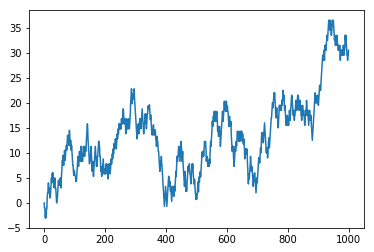

In [104]:
x=[]
for j in range(0,1001):
    x.append(j)
    TotalMoney[j]= (TotalMoney[j] -1000)/1000*100
plt.plot(x,TotalMoney)

# 結論:此算牌策略搭配基本策略以及Kelly公式，以統計學為立足點，似乎真的能夠擴大勝率。然而真正在賭場，不太可能記住每一張牌，進而可能難以使用Kelly公式以及hi-lo策略，因此真正在賭場要獲利還是需要一點運氣